# Image Classification

## Task

Building a classification model using either a base model or a pre-trained model on this dataset.

Dataset Overview:
The dataset features 102 distinct flower categories, each containing between 40 to 258 images. These images showcase diverse characteristics encompassing scale, pose, lighting variations, and intra-category diversity. We've employed isomap visualization using shape and color features for a comprehensive dataset perspective.

Dataset Link: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/


## Tools and Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import seaborn as sns
import tensorflow as tf
from google.colab.patches import cv2_imshow
from google.colab import drive
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense, Dropout,BatchNormalization

## Import Data

There are 2 files for the data
- 102 flowers.tgz: a compressed archive for the image file that contains our dataset
- image labels. mat: is a Matlab file that contains the labels for our dataset.
<br/>
Those different files have different ways and different libraries to deal with them.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile         # To deal with tgz file
path='/content/drive/MyDrive/102flowers.tgz'
tfile = tarfile.open(path, "r:gz")
tfile.extractall('./')
tfile.close()

In [4]:
import scipy.io      #To deal with mat file
mat = scipy.io.loadmat('/content/drive/MyDrive/imagelabels.mat')
label=mat["labels"].tolist()
l=np.reshape(label,(-1,1))

In [5]:
directory='/content/jpg'
files=[os.path.join(directory,f) for f in sorted(os.listdir(directory))]   # a list for the path of every image I have

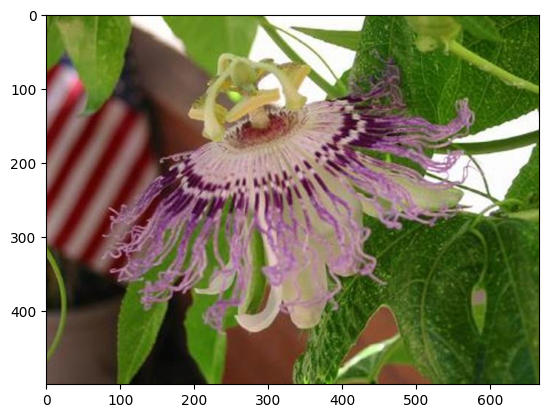

In [ ]:
image=cv2.imread('/content/jpg/image_00007.jpg')
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      #cv2 read the images in the BGR format , in order to show it with matplot library I should convert it to RGB
plt.imshow(image)

In [6]:
# put the file paths with their labels in one place
df=pd.DataFrame(columns=["Files","labels"])        #
df["Files"]=files
df["labels"]=l
df.head()

,Files,labels
0,/content/jpg/image_00001.jpg,77
1,/content/jpg/image_00002.jpg,77
2,/content/jpg/image_00003.jpg,77
3,/content/jpg/image_00004.jpg,77
4,/content/jpg/image_00005.jpg,77


## Images Preprocessing

The first stage for a computer vision project is the preprocessing of the data. In this stage, I prepare the data I have using some techniques to be ready for processing. As our data here is considered as visual data, so. it has different techniques to deal with it than preprocessing written data. The preprocessing may include and not limited to :
<br/>
- Resizing: The data may contain large images. Large images may have more details but when processing them, they will take a lot of time to process, require computational power, take huge memory, and maybe contain unnecessary information. In addition, most image processes like Neural networks, Convolutional neural networks, or pre-trained models require fixed input sizes.
<br/>
-Normalization: It is a process of scaling the pixel values of an image to a standard range (usually from 0 to 1 or -1 to 1).
<br/>
Reason
<br/>
   Each pixel contains information about its color. The values is a number range from 0 to 255. In Colored Images, pixels have 3 values corresponding to the intensity of red, green, and blue RGB (Red - Green - Blue). The range of 0 to 255 is considered a wide range of values as image processing does a lot of multiplications, some weights will dominate the learning process.


<Axes: xlabel='labels', ylabel='count'>

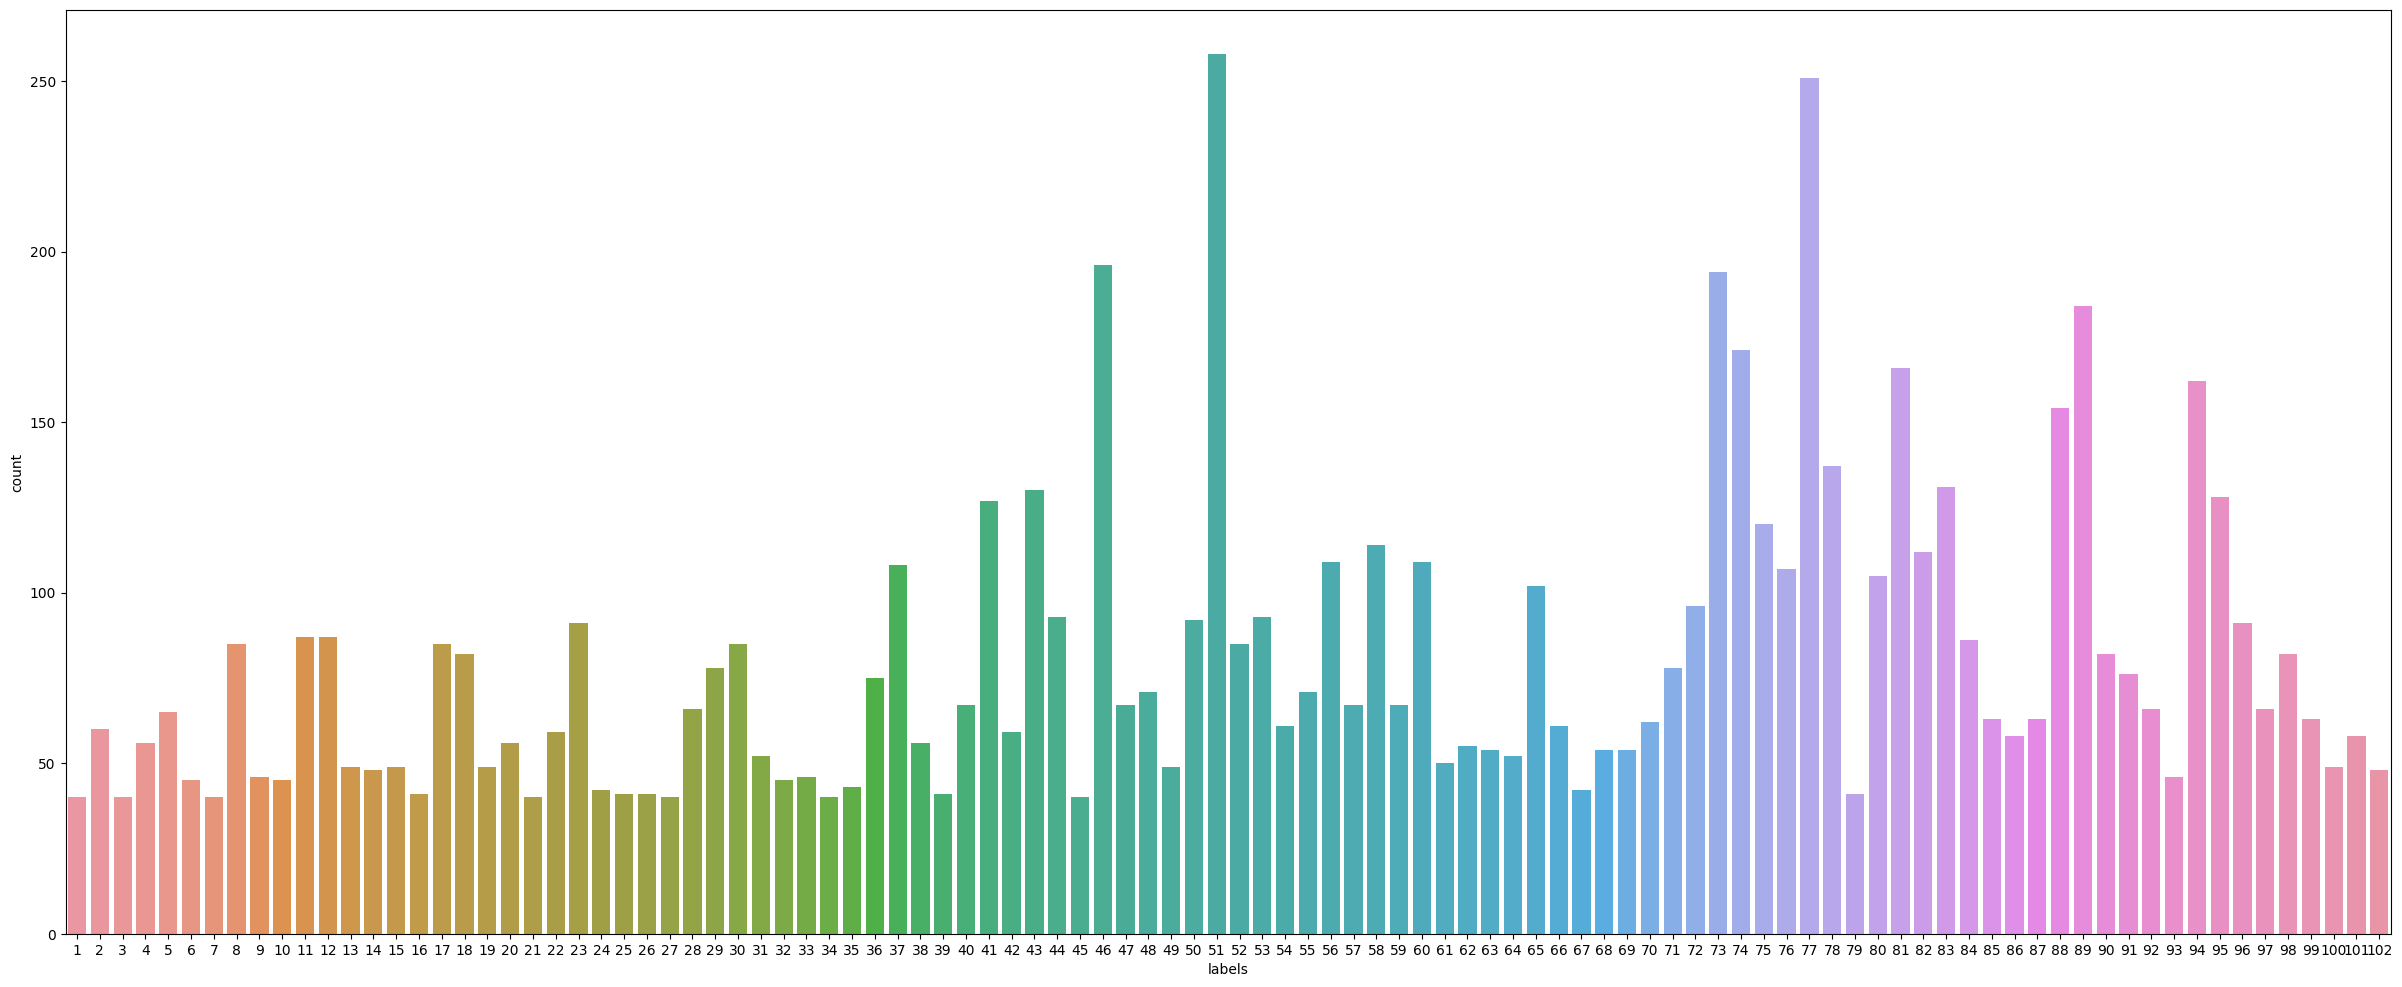

In [7]:
plt.figure(figsize=(30, 12))
sns.countplot(data=df, x='labels')

In [8]:
#Resizing
output_shape = (128,128)   # make all images 80*80 pixels
images=[]
for image_path in files :
  img = Image.open(image_path)
  img_resized = np.array(img.resize(output_shape, Image.ANTIALIAS)) #Image.ANTIALIAS is to preserve the aspect ratio of the images
  images.append(img_resized)


<ipython-input-8-34779c7cba37>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = np.array(img.resize(output_shape, Image.ANTIALIAS)) #Image.ANTIALIAS is to preserve the aspect ratio of the images


In [9]:
images[0].shape

(128, 128, 3)

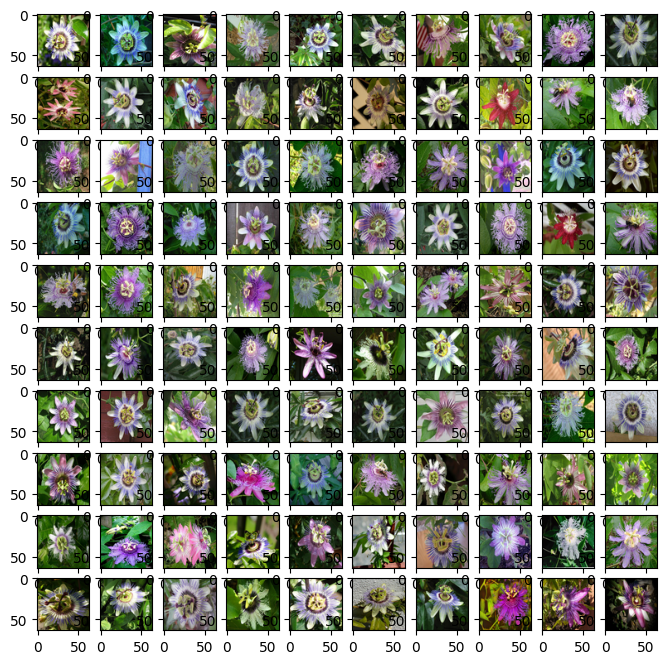

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(images[i])

In [10]:
# normalizing the images

normalized_images = []
for img in images:
    # Convert the image to float32 for normalization
    img_float = img.astype(np.float32)

    # Normalize the pixel values using cv2.NORM_MINMAX
    img_normalized = cv2.normalize(img_float, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Append the normalized image to the list
    normalized_images.append(img_normalized)


In [12]:
normalized_images[1]

array([[[0.00784314, 0.2627451 , 0.13333334],
        [0.01960784, 0.2784314 , 0.14509805],
        [0.01568628, 0.27450982, 0.14901961],
        ...,
        [0.00784314, 0.14901961, 0.11764707],
        [0.00392157, 0.14117648, 0.10196079],
        [0.01960784, 0.19607845, 0.1137255 ]],

       [[0.00784314, 0.34509805, 0.23137257],
        [0.00784314, 0.32941177, 0.19607845],
        [0.03137255, 0.33333334, 0.18431373],
        ...,
        [0.00392157, 0.12941177, 0.09411766],
        [0.00392157, 0.13725491, 0.09803922],
        [0.01960784, 0.19215688, 0.10196079]],

       [[0.02745098, 0.4431373 , 0.33333334],
        [0.00392157, 0.3921569 , 0.26666668],
        [0.01176471, 0.3803922 , 0.23137257],
        ...,
        [0.01568628, 0.11764707, 0.08235294],
        [0.01176471, 0.12941177, 0.08235294],
        [0.01176471, 0.18431373, 0.08235294]],

       ...,

       [[0.0509804 , 0.23137257, 0.05490196],
        [0.07843138, 0.2627451 , 0.03921569],
        [0.08627451, 0

 ## Split the data to trainig and test set

It's a common step to do before training any model. We split our data set into training data set and testing data set. this step will help us evaluate our model, and know if it could generalize on data that it has never seen before. Usually, the data is split into 80% for training and 20% for testing

In [11]:
X=np.array(normalized_images)
y=df["labels"]
Y=np.array(y)
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=40,shuffle=True)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((6551, 128, 128, 3), (6551,), (1638, 128, 128, 3), (1638,))

## Convolutional Neural Network CNN

As the name says, CNN is a type of neural network that is widely used in image classification. It consists of a neural network with some additional steps.CNN has solved some problems that existed in neural networks when dealing with images such as
- reduces the number of input nodes: neural networks tend to take every pixel in the image as an input node which may result in a neural network with hundreds of input nodes and of course wights to calculate and a long time to process and maybe not very useful information (white backgrounds).for example a 32 * 32 pixels image will have 1024 hence it is colored image 1024 * 3 (over the 3 channels) will be 3072 pixels an input nodes. Cause a large neural network over a small picture. you can imagine how many input nodes there will be if we have a larger image
-  tolerate small shifts in the images because CNN can recognize patterns in an image regardless of their position (because of the filters or kernels)

![picture](/content/drive/MyDrive/Capture.PNG)

## Main stages of CNN

### 1. Applying kernels (filters) and producing feature maps

Filters are small-sized matrices used for feature extraction at the beginning of training CNN.
 1. we apply these filters to the input image by overlaying the filter onto the image.
 2. we calculate the dot product between the input image and the filter(multiplication with a local region of the input, followed by summation)
 3. sliding the filter by 1 pixel and repeat that for the whole image
 4. the final results are put into a feature map (every pixel is the dot product of the image and sliding filter)

### 2. Activation Function

 Feature maps go through an activation function. There are many activation functions like sigmoid, softmax,...etc. The common activation function used in CNN is the ReLU activation function. Its job is that if the input is not bringing useful information (negative values from the feature map), return 0 other than that, return the values as it is.
 Returns: features maps with zeros and positive numbers

### 3. Pooling

Pooling is a downsampling operation applied after convolutional layers. It Reduces the spatial dimensions, decreases computational complexity, and helps prevent overfitting. One of the methods of pooling is Max pooling. It's done by Dividing the input feature map into non-overlapping regions (typically squares). For each region, it finds the maximum value (the "max") within that region.
Returns: downsampled version of the input feature map

### 4. Flattening

 THE multi-dimensional tensor or array is transformed into a one-dimensional vector.
 Returns: a linear array that serves as the input to fully connected layers of Neural Networks.

 ### 5. Dense Neural Networks

  It is a fully connected neural network where each neuron in one layer is connected to every neuron in the following layer.
  It consists of neurons, layers, connections(weights), and activation functions. The weights and biases are estimated during training by using an iterative method called backpropagation. The output of the neural networks is the classes or labels you want to classify the data to.






## Part 1 : The convolutional

In [12]:
network=Sequential()
network.add(Conv2D(filters=40,kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
network.add(MaxPool2D(pool_size=(3,3)))
network.add(BatchNormalization())
network.add(Conv2D(filters=32,kernel_size=(2,2),activation='relu'))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(BatchNormalization())
network.add(Conv2D(filters=32,kernel_size=(2,2),activation='relu'))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Flatten())
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 40)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 42, 42, 40)        160       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 32)        5152      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 32)        0         
 g2D)                                                            
                                                        

## Part 2 : Dense neural networks

In [13]:
network.add(Dense(units=307,activation='relu'))
network.add(Dropout(0.3))
network.add(Dense(units=307,activation='relu'))
network.add(Dropout(0.3))
network.add(Dense(units=115,activation='relu'))
network.add(Dense(units=103,activation='softmax'))
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 40)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 42, 42, 40)        160       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 32)        5152      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 32)        0         
 g2D)                                                            
                                                        

In [23]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.5 MB/s eta 0:00:00


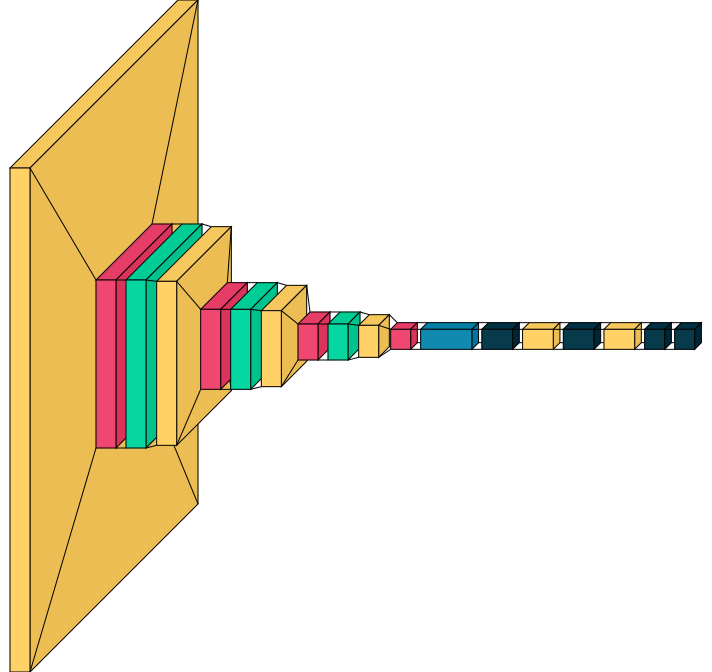

In [24]:
import visualkeras
visualkeras.layered_view(network).show() # display using your system viewer
visualkeras.layered_view(network, to_file='output.png') # write to disk
visualkeras.layered_view(network, to_file='output.png').show() # write and show

visualkeras.layered_view(network)

In [15]:
network.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
history=network.fit(X_train,y_train,epochs=20)

Epoch 1/20
205/205 [==============================] - 103s 492ms/step - loss: 4.1732 - accuracy: 0.0711
Epoch 2/20
205/205 [==============================] - 98s 477ms/step - loss: 3.4270 - accuracy: 0.1557
Epoch 3/20
205/205 [==============================] - 98s 478ms/step - loss: 3.0368 - accuracy: 0.2178
Epoch 4/20
205/205 [==============================] - 99s 485ms/step - loss: 2.7553 - accuracy: 0.2726
Epoch 5/20
205/205 [==============================] - 98s 479ms/step - loss: 2.4897 - accuracy: 0.3320
Epoch 6/20
205/205 [==============================] - 98s 476ms/step - loss: 2.2971 - accuracy: 0.3786
Epoch 7/20
205/205 [==============================] - 100s 486ms/step - loss: 2.1423 - accuracy: 0.4143
Epoch 8/20
205/205 [==============================] - 99s 481ms/step - loss: 1.9468 - accuracy: 0.4599
Epoch 9/20
205/205 [==============================] - 97s 474ms/step - loss: 1.8485 - accuracy: 0.4782
Epoch 10/20
205/205 [==============================] - 100s 488ms/step 

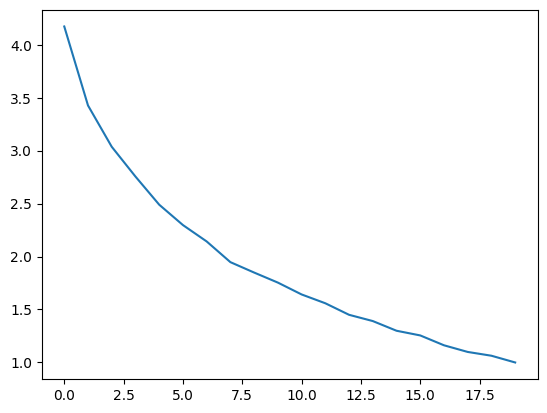

In [21]:
plt.plot(history.history['loss'])

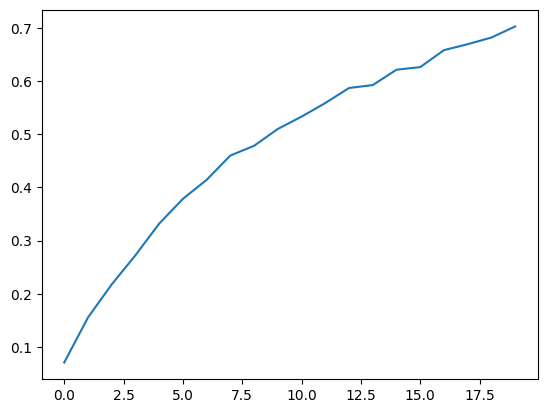

In [22]:
plt.plot(history.history['accuracy'])

In [17]:
predictions=network.predict(X_test)
predictions

52/52 [==============================] - 10s 174ms/step


array([[1.32003874e-08, 2.31953827e-03, 2.64622213e-04, ...,
        8.66307204e-09, 3.99524515e-06, 7.86944611e-07],
       [5.53063501e-06, 2.30460940e-03, 1.31408405e-03, ...,
        3.80279776e-03, 3.55555123e-04, 2.13493666e-04],
       [2.22937398e-11, 1.48216657e-06, 2.45854977e-07, ...,
        4.66207421e-05, 4.09670383e-06, 1.31214540e-06],
       ...,
       [2.94907193e-23, 3.58915074e-18, 3.21646256e-16, ...,
        4.27984178e-22, 1.55758660e-26, 1.29148384e-15],
       [4.91237877e-08, 3.15715370e-05, 6.10598290e-05, ...,
        4.09104068e-05, 1.74668089e-01, 2.01872899e-05],
       [2.39966948e-06, 6.65882953e-06, 3.11498530e-04, ...,
        2.02005589e-03, 4.28754324e-03, 1.01739608e-01]], dtype=float32)

In [18]:
predictions=np.argmax(predictions,axis=1)

In [19]:
predictions

array([ 4, 40, 41, ..., 10, 80, 21])

In [26]:
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(y_test,predictions)

0.5164835164835165

In [32]:
report_dict=classification_report(y_test,predictions,output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
1,0.333333,0.066667,0.111111,15.000000
2,0.846154,0.785714,0.814815,14.000000
3,0.333333,0.090909,0.142857,11.000000
4,0.060606,0.307692,0.101266,13.000000
5,0.200000,0.400000,0.266667,5.000000
...,...,...,...,...
101,0.333333,0.285714,0.307692,14.000000
102,1.000000,0.307692,0.470588,13.000000
accuracy,0.516484,0.516484,0.516484,0.516484
macro avg,0.576300,0.518225,0.510172,1638.000000
